In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00


In [2]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=01fcded0ab65986a8d1d1efea191acd0e8b2ce8b01d74a625cc4b231febb332b
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [3]:
import editdistance
import io
import itertools
import networkx as nx
import nltk
import os
from datasets import load_dataset
import numpy as np
import scipy as sp
from nltk.metrics import precision, recall
import spacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_infix_regex
import math
from rouge_score import rouge_scorer
import regex as re
import matplotlib.pyplot as plt


In [4]:
nlp = spacy.load("en_core_web_sm")

## 1.1 Keyphrase Extraction Dataset

In [33]:
dataset2 = load_dataset("taln-ls2n/inspec", "raw")
test_sample = dataset2["test"][0]
print(test_sample["keyphrases"])

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

['high-fidelity finite element model', 'kidney', 'trauma research', 'National Library of Medicine', 'image segmentation', 'organ reconstruction', 'software package', '2D VHF images', '3D polygonal representation', 'NURBS', 'polygonal surfaces', '3D hexahedral finite element mesh', 'hyperelastic material model', 'biological soft tissues', 'biomechanical research', 'Visible Human Female project', 'medical data set', 'physically based animation', 'nonuniform rational B-spline surfaces', 'viscoelastic model']


Generate Test Dataset

In [34]:
dataset_test2 = dataset2["test"]

## 1.2 Summary Generation Dataset

In [32]:
dataset_sum2 = load_dataset("gopalkalpande/bbc-news-summary")

Generating train split: 0 examples [00:00, ? examples/s]

In [33]:
dataset_sum2_test = dataset_sum2["train"]
print(dataset_sum2_test['Articles'][1])
print(dataset_sum2_test['Summaries'][1])

Army chiefs in regiments decision..Military chiefs are expected to meet to make a final decision on the future of Scotland's Army regiments...A committee of the Army Board, which is made up of the most senior defence figures, will discuss plans for restructuring regiments on Monday. The proposals include cutting Scotland's six single-battalion regiments to five and merging these into a super regiment. The plans have faced stiff opposition from campaigners and politicians alike. The committee's decision must be ratified by Defence Secretary Geoff Hoon and Prime Minister Tony Blair. It is expected that it will be made public next week. When ministers announced a reorganisation of the Army it drew a question mark over the futures of the Black Watch, the Kings Own Scottish Borderers, the Royal Scots, the Royal Highland Fusiliers and the Argyll and Sutherland Highlanders. In October, the Council of Scottish Colonels proposed the merger of the Royal Scots and the King's Own Scottish Borderer

Get Dataset Statistics

In [39]:
def stats(example):
    example["artlen"] = len(example["Articles"].split(' '))
    example["sumlen"] = len(example["Summaries"].split(' '))
    example["numsent"] = len(example["Articles"].split('. '))
    return example
dataset_sum2_test = dataset_sum2["train"]
dset_stats = dataset_sum2_test.map(stats)
# dataset_sum2_test.map(lambda example: {"new_sentence": example["sentence1"]}, remove_columns=["sentence1"])

print(f'Average Article Length = {np.mean(dset_stats["artlen"])}')
print(f'Average Summary Length = {np.mean(dset_stats["sumlen"])}')
print(f'Average Number of Sentences = {np.mean(dset_stats["numsent"])}')
print(f'Average Sentence Length = {np.mean(dset_stats["artlen"])/np.mean(dset_stats["numsent"])}')

Average Article Length = 379.2904676258993
Average Summary Length = 165.20008992805757
Average Number of Sentences = 14.037320143884893
Average Sentence Length = 27.020147986802908


In [5]:
dataset_sum3 = load_dataset('mtc/DUC2004')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/200 [00:00<?, ? examples/s]

In [6]:
dataset_sum3_test = dataset_sum3["train"]
print(dataset_sum3_test['document'][1])
print(dataset_sum3_test['summary'][1])

Federal authorities investigating the murder of a Buffalo-area obstetrician who performed abortions have identified a Vermont man as a material witness to the sniper attack last month and issued a warrant for his arrest Wednesday to bring him in for questioning. The man was identified as James Charles Kopp, 44, whose last known address was in St. Albans, Vt. His whereabouts are not known, investigators said. Investigators said Kopp's car was seen near the Amherst, N.Y., home of Dr. Barnett Slepian in the weeks before the doctor, whose work at an abortion clinic had long made him a target of harassment, was killed. Kopp, according to police records and abortion rights groups, has often moved about the country in a series of protests at abortion clinics, and has been linked to an underground manual that describes methods of killing or maiming doctors who perform abortions. Denise O'Donnell, the U.S. attorney for the western district of New York, said Kopp was not considered a suspect at 

In [38]:
def stats2(example):
    example["artlen"] = len(example["document"].split(' '))
    example["sumlen"] = len(example["summary"].split(' '))
    example["numsent"] = len(example["document"].split('. '))
    return example
dataset_sum3_test = dataset_sum3["train"]
dset_stats = dataset_sum3_test.map(stats2)
# dataset_sum2_test.map(lambda example: {"new_sentence": example["sentence1"]}, remove_columns=["sentence1"])

print(f'Average Article Length = {np.mean(dset_stats["artlen"])}')
print(f'Average Summary Length = {np.mean(dset_stats["sumlen"])}')
print(f'Average Number of Sentences = {np.mean(dset_stats["numsent"])}')
print(f'Average Sentence Length = {np.mean(dset_stats["artlen"])/np.mean(dset_stats["numsent"])}')

Average Article Length = 5891.72
Average Summary Length = 104.57
Average Number of Sentences = 265.08
Average Sentence Length = 22.226195865399127


# 2.0 Keyphrase Extraction

In [7]:
def custom_tokenizer(nlp):
    inf = list(nlp.Defaults.infixes)               # Default infixes
    inf.remove(r"(?<=[0-9])[+\-\*^](?=[0-9-])")    # Remove the generic op between numbers or between a number and a -
    inf = tuple(inf)                               # Convert inf to tuple
    infixes = inf + tuple([r"(?<=[0-9])[+*^](?=[0-9-])", r"(?<=[0-9])-(?=-)"])  # Add the removed rule after subtracting (?<=[0-9])-(?=[0-9]) pattern
    infixes = [x for x in infixes if '-|–|—|--|---|——|~' not in x] # Remove - between letters rule
    infix_re = compile_infix_regex(infixes)

    return Tokenizer(nlp.vocab, prefix_search=nlp.tokenizer.prefix_search,
                                suffix_search=nlp.tokenizer.suffix_search,
                                infix_finditer=infix_re.finditer,
                                token_match=nlp.tokenizer.token_match,
                                rules=nlp.Defaults.tokenizer_exceptions)

In [26]:
#tokenize and clean with spacy
def tokenize(text, tags=['NOUN', 'ADJ', 'PROPN']):
  """Tokenize and remove stopwords using spacy

  :param text: input string text.
  """
  nlp.tokenizer = custom_tokenizer(nlp)
  word_tokens = nlp(text)
  proc_tokens = [token for token in word_tokens if not token.is_stop and token.pos_ in tags and '.' not in token.text]
  return word_tokens, proc_tokens

In [27]:
def build_graph_kw(word_list, weighted=False, window=2):
  gr = nx.Graph() #undirected graph
  gr.add_nodes_from(word_list)

  for i,word in enumerate(word_list):
    co_occur = [id for id in range(i-window+1, i+window) if id>=0 and id<len(word_list) and id!=i]
    for j in co_occur:
      if gr.has_edge(word, word_list[j]):
        if weighted:
          gr[word][word_list[j]]["weight"] += 1.0
        pass
      else:
        gr.add_edge(word, word_list[j], weight=1)
  return gr, len(gr.nodes)

In [8]:
# Modified Python Nx Graph Pagerank Function
def _pagerank_scipy(
    G,
    alpha=0.85,
    personalization=None,
    max_iter=100,
    tol=1.0e-6,
    nstart=None,
    weight="weight",
    dangling=None,
    verbose=False):
  N = len(G)
  if N == 0:
      return {}

  nodelist = list(G)
  A = nx.to_scipy_sparse_array(G, nodelist=nodelist, weight=weight, dtype=float)
  S = A.sum(axis=1)
  S[S != 0] = 1.0 / S[S != 0]
  # TODO: csr_array
  Q = sp.sparse.csr_array(sp.sparse.spdiags(S.T, 0, *A.shape))
  A = Q @ A

  if verbose:
    # print(nodelist)
    print(A)

  # initial vector
  if nstart is None:
      x = np.repeat(1.0, N)
  else:
      x = np.array([nstart.get(n, 0) for n in nodelist], dtype=float)
      x /= x.sum()

  # Personalization vector
  if personalization is None:
      p = np.repeat(1.0 / N, N)
  else:
      p = np.array([personalization.get(n, 0) for n in nodelist], dtype=float)
      if p.sum() == 0:
          raise ZeroDivisionError
      p /= p.sum()
  # Dangling nodes
  if dangling is None:
      dangling_weights = p
  else:
      # Convert the dangling dictionary into an array in nodelist order
      dangling_weights = np.array([dangling.get(n, 0) for n in nodelist], dtype=float)
      dangling_weights /= dangling_weights.sum()
  is_dangling = np.where(S == 0)[0]

  # power iteration: make up to max_iter iterations
  for _ in range(max_iter):
      xlast = x
      x = alpha * (x @ A + sum(x[is_dangling]) * dangling_weights) + (1 - alpha) * p
      if verbose:
        print({n:x[i] for i,n in enumerate(nodelist)})

      # check convergence, l1 norm
      err = np.absolute(x - xlast).sum()
      if err < N * tol:
          return dict(zip(nodelist, map(float, x)))
  raise nx.PowerIterationFailedConvergence(max_iter)


In [29]:
def extract_key_phrases(text, tags=None, weighted=False, window=2, alpha = 0.85, prop=1/3, verbose=False):
  """Return a set of key phrases.

  :param text: input text tokens list.
  """
  if tags is None:
    tags=["NOUN","ADJ","PROPN"]

  textlist, word_list = tokenize(text, tags=tags)

  if verbose:
    print(word_list) #identified tokens

  lem_list = [word.lemma_.lower() for word in word_list]
  graph, num_nodes = build_graph_kw(lem_list, weighted=weighted, window=window)

  # pageRank - initial value of 1.0, error tolerance of 0,0001,
  calculated_page_rank = _pagerank_scipy(graph, alpha = alpha, weight='weight', verbose=verbose)

  # most important words in ascending order of importance
  keyphrases = sorted(calculated_page_rank, key=calculated_page_rank.get, reverse=True)

  if verbose:
    print(keyphrases)

 #return 1/3 of keyphrases
  keyphrases = keyphrases[0:int(num_nodes*prop) + 1]

  if verbose:
    print(keyphrases)

  # take keyphrases with multiple words into consideration as done in the
  # paper - if two words are adjacent in the text and are selected as
  # keywords, join them together
  modified_key_phrases = set([])
  keywords_partial = [] #keywords that exist in keyphrases


  i = 0
  while i < len(textlist):
    if textlist[i].lemma_.lower() in keyphrases:
      phrase_ws = [textlist[i].text.lower()]
      i += 1
      while i < len(textlist) and textlist[i].lemma_.lower() in lem_list:
        phrase_ws.append(textlist[i].text.lower())
        i += 1
      if len(phrase_ws)>1:
        keywords_partial += phrase_ws
      phrase = ' '.join(phrase_ws)
      modified_key_phrases.add(phrase)
    else:
      i += 1

  for x in set(keywords_partial): #removes keywords if they exist in keyphrases
    modified_key_phrases.discard(x)

  return modified_key_phrases

In [30]:
def proc(weighted=False, window=2, alpha=0.85, verbose=False, prop = 1/3, tags = None):
  l = len(dataset_test2)
  keyword_num, corr_keyword_num = 0,0
  prec, rec = np.zeros(l),np.zeros(l)
  for i, data in enumerate(dataset_test2):
    # X = dataset_test[i]['document']
    # y = set(dataset_test[i]['extractive_keyphrases'])
    X = dataset_test2[i]["abstract"]
    y = set([x.lower() for x in dataset_test2[i]['keyphrases']])

    y_pred = extract_key_phrases(X, weighted=weighted, window=window, alpha=alpha, verbose=verbose, tags=tags, prop=prop)

    keyword_num += len(y_pred)
    corr_keyword_num += len(y.intersection(y_pred))
    prec[i] = precision(y, y_pred)
    rec[i] = recall(y, y_pred)

  return prec, rec, keyword_num, corr_keyword_num

In [31]:
def print_stats(prec, rec, keyword_num, corr_keyword_num):
  l = prec.shape[0]
  print(f"Total Keywords: {keyword_num}")
  print(f"Mean Keywords: {keyword_num/l:.3f}")
  print(f"Total Correct Keywords: {corr_keyword_num}")
  print(f"Mean Correct Keywords: {corr_keyword_num/l:.3f}\n")

  print(f"Mean Precision: {np.sum(prec)/l:.3f}")
  print(f"Mean Recall: {np.sum(rec)/l:.3f}")

  with np.errstate(divide='ignore', invalid='ignore'):
    f1 = np.true_divide((2*prec*rec),(prec+rec))
    f1[f1 == np.inf] = 0
    f1 = np.nan_to_num(f1)
  print(f"Mean F-Measure: {np.sum(f1)/l:.3f}\n")

  print(f"Max Precision: {np.max(prec)} (Index: {np.argmax(prec)})")
  print(f"Max Recall: {np.max(rec)} (Index: {np.argmax(rec)})")
  print(f"Max F-Measure: {np.max(f1)} (Index: {np.argmax(f1)})")


## 2.1 Example

In [ ]:
x=dataset_test2[184]['abstract']
print(x)
z=extract_key_phrases(x, verbose=True)
print(z)

We present a two-step integral imaging system to obtain 3-D orthoscopic real images. By adopting a nonstationary micro-optics technique, we demonstrate experimentally the potential usefulness of two-step integral imaging
[two-step, integral, imaging, system, 3-D, orthoscopic, real, images, nonstationary, micro-optics, technique, potential, usefulness, two-step, integral, imaging]
  (0, 12)	0.5
  (0, 1)	0.5
  (1, 2)	0.5
  (1, 0)	0.5
  (2, 3)	0.5
  (2, 1)	0.5
  (3, 4)	0.5
  (3, 2)	0.5
  (4, 5)	0.5
  (4, 3)	0.5
  (5, 6)	0.5
  (5, 4)	0.5
  (6, 7)	0.5
  (6, 5)	0.5
  (7, 8)	0.5
  (7, 6)	0.5
  (8, 9)	0.5
  (8, 7)	0.5
  (9, 10)	0.5
  (9, 8)	0.5
  (10, 11)	0.5
  (10, 9)	0.5
  (11, 12)	0.5
  (11, 10)	0.5
  (12, 11)	0.5
  (12, 0)	0.5
{'two-step': 0.8615384615384615, 'integral': 0.8615384615384615, 'imaging': 0.8615384615384615, 'system': 0.8615384615384615, '3-d': 0.8615384615384615, 'orthoscopic': 0.8615384615384615, 'real': 0.8615384615384615, 'image': 0.8615384615384615, 'nonstationary': 0.861

In [ ]:
print(dataset_test2[184]['keyphrases'])

['two-step integral imaging', 'two-step integral imaging system', '3-D orthoscopic real images', 'nonstationary micro-optics technique', 'resolution improved viewing', '3-D image reconstruction', 'liquid crystal light valve', 'display device', 'LCLV', 'pickup lenslet array']


## 2.2 Base

In [ ]:
prec, rec, kw, ckw = proc()
print_stats(prec,rec,kw,ckw)

Total Keywords: 6114
Mean Keywords: 12.228
Total Correct Keywords: 1322
Mean Correct Keywords: 2.644

Mean Precision: 0.224
Mean Recall: 0.269
Mean F-Measure: 0.232

Max Precision: 1.0 (Index: 184)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.7692307692307693 (Index: 348)


## 2.3 Weighted Graph

In [ ]:
prec, rec, kw, ckw = proc(weighted=True)
print_stats(prec,rec,kw,ckw)

Total Keywords: 6084
Mean Keywords: 12.168
Total Correct Keywords: 1328
Mean Correct Keywords: 2.656

Mean Precision: 0.226
Mean Recall: 0.271
Mean F-Measure: 0.234

Max Precision: 1.0 (Index: 343)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.7692307692307693 (Index: 348)


## 2.4 Part of Speech Combinations

In [ ]:
#other word types
print('--------------------Tags = NOUN,VERB,ADJ,PROPN--------------------\n')
prec, rec, kw, ckw = proc(tags=['NOUN','VERB','ADJ','PROPN'])
print_stats(prec,rec,kw,ckw)
print('--------------------Tags = NOUN,VERB,ADJ,ADV,PROPN--------------------\n')
prec, rec, kw, ckw = proc(tags=['NOUN','VERB','ADJ','PROPN','ADV'])
print_stats(prec,rec,kw,ckw)
print('--------------------Tags = NOUN,ADJ--------------------\n')
prec, rec, kw, ckw = proc(tags=['NOUN','ADJ'])
print_stats(prec,rec,kw,ckw)


--------------------Tags = NOUN,VERB,ADJ,PROPN--------------------

Total Keywords: 7656
Mean Keywords: 15.312
Total Correct Keywords: 1288
Mean Correct Keywords: 2.576

Mean Precision: 0.173
Mean Recall: 0.262
Mean F-Measure: 0.198

Max Precision: 0.7142857142857143 (Index: 348)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.6666666666666666 (Index: 348)
--------------------Tags = NOUN,VERB,ADJ,ADV,PROPN--------------------

Total Keywords: 7802
Mean Keywords: 15.604
Total Correct Keywords: 1290
Mean Correct Keywords: 2.580

Mean Precision: 0.171
Mean Recall: 0.262
Mean F-Measure: 0.196

Max Precision: 0.7142857142857143 (Index: 348)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.6666666666666666 (Index: 348)
--------------------Tags = NOUN,ADJ--------------------

Total Keywords: 5737
Mean Keywords: 11.474
Total Correct Keywords: 1188
Mean Correct Keywords: 2.376

Mean Precision: 0.215
Mean Recall: 0.238
Mean F-Measure: 0.214

Max Precision: 1.0 (Index: 184)
Max Recall: 1.0 (Index: 19)
M

## 2.5 Co-Occurrence Window Sizes

In [35]:
#co occurrence window size
for w in [3,4,5,6,7,8,9,10]:
  print(f'--------------------Window Size = {w}--------------------\n')
  prec, rec, kw, ckw = proc(window=w)
  print_stats(prec,rec,kw,ckw)

--------------------Window Size = 3--------------------

Total Keywords: 6015
Mean Keywords: 12.030
Total Correct Keywords: 1304
Mean Correct Keywords: 2.608

Mean Precision: 0.223
Mean Recall: 0.265
Mean F-Measure: 0.230

Max Precision: 1.0 (Index: 184)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.7692307692307693 (Index: 348)
--------------------Window Size = 4--------------------

Total Keywords: 5985
Mean Keywords: 11.970
Total Correct Keywords: 1325
Mean Correct Keywords: 2.650

Mean Precision: 0.227
Mean Recall: 0.270
Mean F-Measure: 0.235

Max Precision: 1.0 (Index: 184)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.7692307692307693 (Index: 348)
--------------------Window Size = 5--------------------

Total Keywords: 5979
Mean Keywords: 11.958
Total Correct Keywords: 1316
Mean Correct Keywords: 2.632

Mean Precision: 0.225
Mean Recall: 0.268
Mean F-Measure: 0.233

Max Precision: 1.0 (Index: 155)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.7499999999999999 (Index: 155)
----------

## 2.6 Proportion of Keywords Retained

In [ ]:
for w in [1/4,2/3,3/4,4/5]:
  print(f'--------------------Prop = {w}--------------------\n')
  prec, rec, kw, ckw = proc(prop=w)
  print_stats(prec,rec,kw,ckw)

--------------------Prop = 0.25--------------------

Total Keywords: 5093
Mean Keywords: 10.186
Total Correct Keywords: 1100
Mean Correct Keywords: 2.200

Mean Precision: 0.221
Mean Recall: 0.225
Mean F-Measure: 0.211

Max Precision: 1.0 (Index: 184)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.7 (Index: 302)
--------------------Prop = 0.6666666666666666--------------------

Total Keywords: 9605
Mean Keywords: 19.210
Total Correct Keywords: 2003
Mean Correct Keywords: 4.006

Mean Precision: 0.219
Mean Recall: 0.407
Mean F-Measure: 0.272

Max Precision: 1.0 (Index: 184)
Max Recall: 1.0 (Index: 6)
Max F-Measure: 0.75 (Index: 348)
--------------------Prop = 0.75--------------------

Total Keywords: 10297
Mean Keywords: 20.594
Total Correct Keywords: 2146
Mean Correct Keywords: 4.292

Mean Precision: 0.218
Mean Recall: 0.431
Mean F-Measure: 0.277

Max Precision: 1.0 (Index: 184)
Max Recall: 1.0 (Index: 6)
Max F-Measure: 0.7058823529411765 (Index: 348)
--------------------Prop = 0.8--------

In [ ]:
#sentence separation and only keywords
prec, rec, kw, ckw = proc()
print_stats(prec,rec,kw,ckw)

Total Keywords: 5554
Mean Keywords: 11.108
Total Correct Keywords: 652
Mean Correct Keywords: 1.304

Mean Precision: 0.121
Mean Recall: 0.137
Mean F-Measure: 0.122

Max Precision: 1.0 (Index: 387)
Max Recall: 0.6666666666666666 (Index: 265)
Max F-Measure: 0.6666666666666666 (Index: 387)


In [ ]:
#sentence separation and any word
prec, rec, kw, ckw = proc()
print_stats(prec,rec,kw,ckw)

Total Keywords: 6290
Mean Keywords: 12.580
Total Correct Keywords: 1342
Mean Correct Keywords: 2.684

Mean Precision: 0.221
Mean Recall: 0.277
Mean F-Measure: 0.234

Max Precision: 0.8 (Index: 241)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.75 (Index: 496)


In [ ]:
#any word
prec, rec, kw, ckw = proc()
print_stats(prec,rec,kw,ckw)

Total Keywords: 6114
Mean Keywords: 12.228
Total Correct Keywords: 1322
Mean Correct Keywords: 2.644

Mean Precision: 0.224
Mean Recall: 0.269
Mean F-Measure: 0.232

Max Precision: 1.0 (Index: 184)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.7692307692307693 (Index: 348)


In [ ]:
#no jumping #doesnt work
ec, rec, kw, ckw = proc(alpha=0.9)
print_stats(prec,rec,kw,ckw)

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

In [ ]:
#weighted
prec, rec, kw, ckw = proc(weighted=True)
print_stats(prec,rec,kw,ckw)

Total Keywords: 6084
Mean Keywords: 12.168
Total Correct Keywords: 1328
Mean Correct Keywords: 2.656

Mean Precision: 0.226
Mean Recall: 0.271
Mean F-Measure: 0.234

Max Precision: 1.0 (Index: 343)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.7692307692307693 (Index: 348)


In [ ]:
#other word types
print('--------------------Tags = NOUN,VERB,ADJ,PROPN--------------------\n')
prec, rec, kw, ckw = proc(tags=['NOUN','VERB','ADJ','PROPN'])
print_stats(prec,rec,kw,ckw)
print('--------------------Tags = NOUN,VERB,ADJ,ADV,PROPN--------------------\n')
prec, rec, kw, ckw = proc(tags=['NOUN','VERB','ADJ','PROPN','ADV'])
print_stats(prec,rec,kw,ckw)
print('--------------------Tags = NOUN,ADJ--------------------\n')
prec, rec, kw, ckw = proc(tags=['NOUN','ADJ'])
print_stats(prec,rec,kw,ckw)


--------------------Tags = NOUN,VERB,ADJ,PROPN--------------------

Total Keywords: 7629
Mean Keywords: 15.258
Total Correct Keywords: 1290
Mean Correct Keywords: 2.580

Mean Precision: 0.174
Mean Recall: 0.262
Mean F-Measure: 0.198

Max Precision: 0.7142857142857143 (Index: 348)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.6666666666666666 (Index: 348)
--------------------Tags = NOUN,VERB,ADJ,ADV,PROPN--------------------

Total Keywords: 7777
Mean Keywords: 15.554
Total Correct Keywords: 1294
Mean Correct Keywords: 2.588

Mean Precision: 0.172
Mean Recall: 0.264
Mean F-Measure: 0.197

Max Precision: 0.7142857142857143 (Index: 348)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.6666666666666666 (Index: 348)
--------------------Tags = NOUN,ADJ--------------------

Total Keywords: 5692
Mean Keywords: 11.384
Total Correct Keywords: 1186
Mean Correct Keywords: 2.372

Mean Precision: 0.216
Mean Recall: 0.238
Mean F-Measure: 0.215

Max Precision: 1.0 (Index: 184)
Max Recall: 1.0 (Index: 19)
M

In [ ]:
#co occurrence window size
for w in [3,5,10]:
  print(f'--------------------Window Size = {w}--------------------\n')
  prec, rec, kw, ckw = proc(window=w)
  print_stats(prec,rec,kw,ckw)

--------------------Window Size = 3--------------------

Total Keywords: 5977
Mean Keywords: 11.954
Total Correct Keywords: 1306
Mean Correct Keywords: 2.612

Mean Precision: 0.224
Mean Recall: 0.266
Mean F-Measure: 0.231

Max Precision: 1.0 (Index: 184)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.7692307692307693 (Index: 348)
--------------------Window Size = 5--------------------

Total Keywords: 5948
Mean Keywords: 11.896
Total Correct Keywords: 1316
Mean Correct Keywords: 2.632

Mean Precision: 0.225
Mean Recall: 0.268
Mean F-Measure: 0.233

Max Precision: 1.0 (Index: 155)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.7499999999999999 (Index: 155)
--------------------Window Size = 10--------------------

Total Keywords: 5818
Mean Keywords: 11.636
Total Correct Keywords: 1313
Mean Correct Keywords: 2.626

Mean Precision: 0.233
Mean Recall: 0.266
Mean F-Measure: 0.235

Max Precision: 1.0 (Index: 184)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.6666666666666666 (Index: 16)


In [ ]:
#proportion of keywords retained

## 2.7 Sentence Separation

In [ ]:
#tokenize and clean with spacy
def tokenize2(text, tags=['NOUN', 'ADJ', 'PROPN']):
  """Tokenize and remove stopwords using spacy

  :param text: input string text.
  """
  # nlp = spacy.load("en_core_web_sm")

  nlp.tokenizer = custom_tokenizer(nlp)
  # word_tokens = nlp(Doc(nlp.vocab, text))
  # stopwords = [x.lower() for x in nlp.pipe_labels['tagger']] #custom stopwords
  word_tokens = nlp(text)
  sents = [sent for sent in word_tokens.sents]
  # print([(token.text, token.pos_) for token in word_tokens])
  # print(word_tokens.ents)
  # entities = [x.text for x in word_tokens.ents]
  # print(entities) #cannot bc entities can be multiple words long...

  # proc_tokens = [token for token in word_tokens if not token.is_stop and token.pos_ in tags and '.' not in token.text]
  proc_tokens = [[token for token in sent if not token.is_stop and token.pos_ in tags and '.' not in token.text] for sent in sents]

  # final_tokens = [token.text.lower() for token in proc_tokens]
  # final_lem = [token.lemma_.lower() for token in proc_tokens]
  return word_tokens, proc_tokens

In [ ]:
def build_graph_kw2(lem_list, weighted=False, window=2):
  # words = list(set(word_list))
  words = [word for sent in lem_list for word in sent]

  gr = nx.Graph() #undirected graph
  gr.add_nodes_from(words)

  for sent in lem_list:
    for i,word in enumerate(sent):
      co_occur = [id for id in range(i-window+1, i+window) if id>=0 and id<len(sent) and id!=i]
      for j in co_occur:
        if gr.has_edge(word, sent[j]):
          if weighted:
            gr[word][sent[j]]["weight"] += 1.0
          pass
        else:
          gr.add_edge(word, sent[j], weight=1)
  return gr, len(gr.nodes)

In [ ]:
def extract_key_phrases2(text, tags=None, weighted=False, window=2, alpha = 0.85, verbose=False):
  """Return a set of key phrases.

  :param text: input text tokens list.
  """
  if tags is None:
    tags=["NOUN","ADJ","PROPN"]

  textlist, word_list = tokenize2(text, tags=tags)

  if verbose:
    print(word_list) #identified tokens

  lem_list = [[word.lemma_.lower() for word in sent] for sent in word_list]

  graph, num_nodes = build_graph_kw2(lem_list, weighted=weighted, window=window)

  # pageRank - initial value of 1.0, error tolerance of 0,0001,
  calculated_page_rank = _pagerank_scipy(graph, alpha = alpha, weight='weight', verbose=verbose)

  # most important words in ascending order of importance
  keyphrases = sorted(calculated_page_rank, key=calculated_page_rank.get, reverse=True)

  if verbose:
    print(keyphrases)

 #return 1/3 of keyphrases
  keyphrases = keyphrases[0:int(num_nodes // 3) + 1]

  if verbose:
    print(keyphrases)

  # take keyphrases with multiple words into consideration as done in the
  # paper - if two words are adjacent in the text and are selected as
  # keywords, join them together
  modified_key_phrases = set([])
  keywords_partial = [] #keywords that exist in keyphrases

  lems = set([word for sent in lem_list for word in sent])


  i = 0
  while i < len(textlist):
    if textlist[i].lemma_.lower() in keyphrases:
      phrase_ws = [textlist[i].text.lower()]
      i += 1
      while i < len(textlist) and textlist[i].lemma_.lower() in lems:
        phrase_ws.append(textlist[i].text.lower())
        i += 1
      if len(phrase_ws)>1:
        keywords_partial += phrase_ws
      phrase = ' '.join(phrase_ws)
      modified_key_phrases.add(phrase)
    else:
      i += 1

  for x in set(keywords_partial): #removes keywords if they exist in keyphrases
    modified_key_phrases.discard(x)

  return modified_key_phrases

In [ ]:
def proc2(weighted=False, window=2, alpha=0.85, verbose=False, prop = 1/3, tags = None):
  l = len(dataset_test2)
  keyword_num, corr_keyword_num = 0,0
  prec, rec = np.zeros(l),np.zeros(l)
  for i, data in enumerate(dataset_test2):
    X = dataset_test2[i]["abstract"]
    y = set([x.lower() for x in dataset_test2[i]['keyphrases']])

    y_pred = extract_key_phrases2(X, weighted=weighted, window=window, alpha=alpha, verbose=verbose, tags=tags)

    keyword_num += len(y_pred)
    corr_keyword_num += len(y.intersection(y_pred))
    prec[i] = precision(y, y_pred)
    rec[i] = recall(y, y_pred)

  return prec, rec, keyword_num, corr_keyword_num

In [ ]:
prec, rec, kw, ckw = proc2()
print_stats(prec,rec,kw,ckw)

Total Keywords: 6290
Mean Keywords: 12.580
Total Correct Keywords: 1342
Mean Correct Keywords: 2.684

Mean Precision: 0.221
Mean Recall: 0.277
Mean F-Measure: 0.234

Max Precision: 0.8 (Index: 241)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.75 (Index: 496)


Example:

In [ ]:
x=dataset_test2[184]['abstract']
print(x)
z=extract_key_phrases2(x, verbose=True)
print(z)

We present a two-step integral imaging system to obtain 3-D orthoscopic real images. By adopting a nonstationary micro-optics technique, we demonstrate experimentally the potential usefulness of two-step integral imaging
[[two-step, integral, imaging, system, 3-D, orthoscopic, real, images], [nonstationary, micro-optics, technique, potential, usefulness, two-step, integral, imaging]]
  (0, 12)	0.5
  (0, 1)	0.5
  (1, 2)	0.5
  (1, 0)	0.5
  (2, 3)	0.5
  (2, 1)	0.5
  (3, 4)	0.5
  (3, 2)	0.5
  (4, 5)	0.5
  (4, 3)	0.5
  (5, 6)	0.5
  (5, 4)	0.5
  (6, 7)	0.5
  (6, 5)	0.5
  (7, 6)	1.0
  (8, 9)	1.0
  (9, 10)	0.5
  (9, 8)	0.5
  (10, 11)	0.5
  (10, 9)	0.5
  (11, 12)	0.5
  (11, 10)	0.5
  (12, 11)	0.5
  (12, 0)	0.5
{'two-step': 0.8615384615384615, 'integral': 0.8615384615384615, 'imaging': 0.8615384615384615, 'system': 0.8615384615384615, '3-d': 0.8615384615384615, 'orthoscopic': 0.8615384615384615, 'real': 1.2865384615384614, 'image': 0.43653846153846154, 'nonstationary': 0.43653846153846154, 'micr

## 2.8 Return Only Keyphrases

In [ ]:
def extract_key_phrases_ss(text, tags=None, weighted=False, window=2, alpha = 0.85, prop=1/3, verbose=False):
  """Return a set of key phrases.

  :param text: input text tokens list.
  """
  if tags is None:
    tags=["NOUN","ADJ","PROPN"]

  textlist, word_list = tokenize(text, tags=tags)

  if verbose:
    print(word_list) #identified tokens

  lem_list = [word.lemma_.lower() for word in word_list]
  graph, num_nodes = build_graph_kw(lem_list, weighted=weighted, window=window)

  # pageRank - initial value of 1.0, error tolerance of 0,0001,
  calculated_page_rank = _pagerank_scipy(graph, alpha = alpha, weight='weight', verbose=verbose)

  # most important words in ascending order of importance
  keyphrases = sorted(calculated_page_rank, key=calculated_page_rank.get, reverse=True)

  if verbose:
    print(keyphrases)

 #return 1/3 of keyphrases
  keyphrases = keyphrases[0:int(num_nodes*prop) + 1]

  if verbose:
    print(keyphrases)

  # take keyphrases with multiple words into consideration as done in the
  # paper - if two words are adjacent in the text and are selected as
  # keywords, join them together
  modified_key_phrases = set([])
  keywords_partial = [] #keywords that exist in keyphrases


  i = 0
  while i < len(textlist):
    if textlist[i].lemma_.lower() in keyphrases:
      phrase_ws = [textlist[i].text.lower()]
      i += 1
      while i < len(textlist) and textlist[i].lemma_.lower() in keyphrases:
        phrase_ws.append(textlist[i].text.lower())
        i += 1
      if len(phrase_ws)>1:
        keywords_partial += phrase_ws
      phrase = ' '.join(phrase_ws)
      modified_key_phrases.add(phrase)
    else:
      i += 1

  for x in set(keywords_partial): #removes keywords if they exist in keyphrases
    modified_key_phrases.discard(x)

  return modified_key_phrases

In [ ]:
def proc_ss(weighted=False, window=2, alpha=0.85, verbose=False, prop = 1/3, tags = None):
  l = len(dataset_test2)
  keyword_num, corr_keyword_num = 0,0
  prec, rec = np.zeros(l),np.zeros(l)
  for i, data in enumerate(dataset_test2):
    # X = dataset_test[i]['document']
    # y = set(dataset_test[i]['extractive_keyphrases'])
    X = dataset_test2[i]["abstract"]
    y = set([x.lower() for x in dataset_test2[i]['keyphrases']])

    y_pred = extract_key_phrases_ss(X, weighted=weighted, window=window, alpha=alpha, verbose=verbose, tags=tags, prop=prop)

    keyword_num += len(y_pred)
    corr_keyword_num += len(y.intersection(y_pred))
    prec[i] = precision(y, y_pred)
    rec[i] = recall(y, y_pred)

  return prec, rec, keyword_num, corr_keyword_num

In [ ]:
prec, rec, kw, ckw = proc_ss()
print_stats(prec,rec,kw,ckw)

Total Keywords: 5427
Mean Keywords: 10.854
Total Correct Keywords: 761
Mean Correct Keywords: 1.522

Mean Precision: 0.145
Mean Recall: 0.158
Mean F-Measure: 0.144

Max Precision: 0.8 (Index: 9)
Max Recall: 0.6666666666666666 (Index: 99)
Max F-Measure: 0.5714285714285714 (Index: 9)


Example:

In [ ]:
x=dataset_test2[184]['abstract']
print(x)
z=extract_key_phrases_ss(x, verbose=True)
print(z)

We present a two-step integral imaging system to obtain 3-D orthoscopic real images. By adopting a nonstationary micro-optics technique, we demonstrate experimentally the potential usefulness of two-step integral imaging
[two-step, integral, imaging, system, 3-D, orthoscopic, real, images, nonstationary, micro-optics, technique, potential, usefulness, two-step, integral, imaging]
  (0, 12)	0.5
  (0, 1)	0.5
  (1, 2)	0.5
  (1, 0)	0.5
  (2, 3)	0.5
  (2, 1)	0.5
  (3, 4)	0.5
  (3, 2)	0.5
  (4, 5)	0.5
  (4, 3)	0.5
  (5, 6)	0.5
  (5, 4)	0.5
  (6, 7)	0.5
  (6, 5)	0.5
  (7, 8)	0.5
  (7, 6)	0.5
  (8, 9)	0.5
  (8, 7)	0.5
  (9, 10)	0.5
  (9, 8)	0.5
  (10, 11)	0.5
  (10, 9)	0.5
  (11, 12)	0.5
  (11, 10)	0.5
  (12, 11)	0.5
  (12, 0)	0.5
{'two-step': 0.8615384615384615, 'integral': 0.8615384615384615, 'imaging': 0.8615384615384615, 'system': 0.8615384615384615, '3-d': 0.8615384615384615, 'orthoscopic': 0.8615384615384615, 'real': 0.8615384615384615, 'image': 0.8615384615384615, 'nonstationary': 0.861

## 2.9 No Random Jumping in Graph

In [ ]:
#no jumping #doesnt work
ec, rec, kw, ckw = proc(alpha=0.9)
print_stats(prec,rec,kw,ckw)

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

## 2.10 Directed Graphs

In [ ]:
def build_graph_kw_fw(word_list, weighted=False, window=2):
  gr = nx.DiGraph() #undirected graph
  gr.add_nodes_from(word_list)

  for i,word in enumerate(word_list):
    co_occur = [id for id in range(i+1, i+window) if id>=0 and id<len(word_list) and id!=i]
    for j in co_occur:
      if gr.has_edge(word, word_list[j]):
        if weighted:
          gr[word][word_list[j]]["weight"] += 1.0
        pass
      else:
        gr.add_edge(word, word_list[j], weight=1)
  return gr, len(gr.nodes)

In [ ]:
def build_graph_kw_bw(word_list, weighted=False, window=2):
  gr = nx.DiGraph() #undirected graph
  gr.add_nodes_from(word_list)

  for i,word in enumerate(word_list):
    co_occur = [id for id in range(i-window+1, i) if id>=0 and id<len(word_list) and id!=i]
    for j in co_occur:
      if gr.has_edge(word, word_list[j]):
        if weighted:
          gr[word][word_list[j]]["weight"] += 1.0
        pass
      else:
        gr.add_edge(word, word_list[j], weight=1)
  return gr, len(gr.nodes)

In [ ]:
def extract_key_phrases_dir(text, tags=None, weighted=False, window=2, alpha = 0.85, prop=1/3, verbose=False, forward=True):
  """Return a set of key phrases.

  :param text: input text tokens list.
  """
  if tags is None:
    tags=["NOUN","ADJ","PROPN"]

  textlist, word_list = tokenize(text, tags=tags)

  if verbose:
    print(word_list) #identified tokens

  lem_list = [word.lemma_.lower() for word in word_list]
  if forward:
    graph, num_nodes = build_graph_kw_fw(lem_list, weighted=weighted, window=window)
  else:
    graph, num_nodes = build_graph_kw_bw(lem_list, weighted=weighted, window=window)

  # pageRank - initial value of 1.0, error tolerance of 0,0001,
  calculated_page_rank = _pagerank_scipy(graph, alpha = alpha, weight='weight', verbose=verbose)

  # most important words in ascending order of importance
  keyphrases = sorted(calculated_page_rank, key=calculated_page_rank.get, reverse=True)

  if verbose:
    print(keyphrases)

 #return 1/3 of keyphrases
  keyphrases = keyphrases[0:int(num_nodes*prop) + 1]

  if verbose:
    print(keyphrases)

  # take keyphrases with multiple words into consideration as done in the
  # paper - if two words are adjacent in the text and are selected as
  # keywords, join them together
  modified_key_phrases = set([])
  keywords_partial = [] #keywords that exist in keyphrases


  i = 0
  while i < len(textlist):
    if textlist[i].lemma_.lower() in keyphrases:
      phrase_ws = [textlist[i].text.lower()]
      i += 1
      while i < len(textlist) and textlist[i].lemma_.lower() in lem_list:
        phrase_ws.append(textlist[i].text.lower())
        i += 1
      if len(phrase_ws)>1:
        keywords_partial += phrase_ws
      phrase = ' '.join(phrase_ws)
      modified_key_phrases.add(phrase)
    else:
      i += 1

  for x in set(keywords_partial): #removes keywords if they exist in keyphrases
    modified_key_phrases.discard(x)

  return modified_key_phrases

In [ ]:
def proc_dir(forward=True, weighted=False, window=2, alpha=0.85, verbose=False, prop = 1/3, tags = None):
  l = len(dataset_test2)
  keyword_num, corr_keyword_num = 0,0
  prec, rec = np.zeros(l),np.zeros(l)
  for i, data in enumerate(dataset_test2):
    # X = dataset_test[i]['document']
    # y = set(dataset_test[i]['extractive_keyphrases'])
    X = dataset_test2[i]["abstract"]
    y = set([x.lower() for x in dataset_test2[i]['keyphrases']])

    y_pred = extract_key_phrases_dir(X, weighted=weighted, window=window, alpha=alpha, verbose=verbose, tags=tags, prop=prop, forward=True)

    keyword_num += len(y_pred)
    corr_keyword_num += len(y.intersection(y_pred))
    prec[i] = precision(y, y_pred)
    rec[i] = recall(y, y_pred)

  return prec, rec, keyword_num, corr_keyword_num

Forward:

In [ ]:
prec, rec, kw, ckw = proc_dir()
print_stats(prec,rec,kw,ckw)

Total Keywords: 5871
Mean Keywords: 11.742
Total Correct Keywords: 1261
Mean Correct Keywords: 2.522

Mean Precision: 0.223
Mean Recall: 0.256
Mean F-Measure: 0.226

Max Precision: 1.0 (Index: 184)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.7692307692307693 (Index: 348)


Backward:

In [ ]:
prec, rec, kw, ckw = proc_dir(forward=False)
print_stats(prec,rec,kw,ckw)

Total Keywords: 5871
Mean Keywords: 11.742
Total Correct Keywords: 1261
Mean Correct Keywords: 2.522

Mean Precision: 0.223
Mean Recall: 0.256
Mean F-Measure: 0.226

Max Precision: 1.0 (Index: 184)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.7692307692307693 (Index: 348)


In [ ]:
x=dataset_test2[184]['abstract']
print(x)
z=extract_key_phrases_dir(x, verbose=True, forward=False)
print(z)

We present a two-step integral imaging system to obtain 3-D orthoscopic real images. By adopting a nonstationary micro-optics technique, we demonstrate experimentally the potential usefulness of two-step integral imaging
[two-step, integral, imaging, system, 3-D, orthoscopic, real, images, nonstationary, micro-optics, technique, potential, usefulness, two-step, integral, imaging]
  (0, 12)	1.0
  (1, 0)	1.0
  (2, 1)	1.0
  (3, 2)	1.0
  (4, 3)	1.0
  (5, 4)	1.0
  (6, 5)	1.0
  (7, 6)	1.0
  (8, 7)	1.0
  (9, 8)	1.0
  (10, 9)	1.0
  (11, 10)	1.0
  (12, 11)	1.0
{'two-step': 0.8615384615384615, 'integral': 0.8615384615384615, 'imaging': 0.8615384615384615, 'system': 0.8615384615384615, '3-d': 0.8615384615384615, 'orthoscopic': 0.8615384615384615, 'real': 0.8615384615384615, 'image': 0.8615384615384615, 'nonstationary': 0.8615384615384615, 'micro-optics': 0.8615384615384615, 'technique': 0.8615384615384615, 'potential': 0.8615384615384615, 'usefulness': 0.8615384615384615}
{'two-step': 0.743846153

In [ ]:
print(np.argwhere(rec==0))
# print(prec)

[[ 13]
 [ 14]
 [ 29]
 [ 30]
 [ 37]
 [ 67]
 [ 70]
 [ 74]
 [ 80]
 [ 81]
 [ 89]
 [ 91]
 [125]
 [126]
 [129]
 [133]
 [134]
 [135]
 [146]
 [163]
 [164]
 [169]
 [182]
 [187]
 [189]
 [197]
 [203]
 [212]
 [220]
 [223]
 [224]
 [227]
 [232]
 [234]
 [248]
 [249]
 [252]
 [278]
 [289]
 [315]
 [324]
 [327]
 [328]
 [342]
 [345]
 [351]
 [359]
 [362]
 [365]
 [368]
 [388]
 [389]
 [395]
 [396]
 [417]
 [435]
 [454]
 [471]
 [475]
 [482]
 [483]
 [495]]


In [ ]:
print(np.argwhere(prec==0))


[[  7]
 [ 11]
 [ 13]
 [ 14]
 [ 18]
 [ 29]
 [ 30]
 [ 37]
 [ 67]
 [ 69]
 [ 70]
 [ 74]
 [ 80]
 [ 81]
 [ 89]
 [ 91]
 [105]
 [107]
 [125]
 [126]
 [128]
 [129]
 [133]
 [134]
 [135]
 [146]
 [159]
 [163]
 [164]
 [169]
 [170]
 [182]
 [187]
 [189]
 [191]
 [192]
 [193]
 [197]
 [203]
 [207]
 [212]
 [213]
 [220]
 [223]
 [224]
 [227]
 [232]
 [234]
 [236]
 [242]
 [246]
 [248]
 [249]
 [252]
 [257]
 [270]
 [278]
 [289]
 [291]
 [296]
 [315]
 [324]
 [327]
 [328]
 [340]
 [342]
 [345]
 [347]
 [351]
 [359]
 [362]
 [365]
 [367]
 [368]
 [388]
 [389]
 [391]
 [392]
 [393]
 [395]
 [396]
 [407]
 [409]
 [414]
 [417]
 [430]
 [435]
 [444]
 [454]
 [466]
 [470]
 [471]
 [475]
 [482]
 [483]
 [489]
 [495]
 [499]]


# 3.0 Summary Generation

Run the custom_tokenizer() function in part 2.0 first.

In [9]:
#tokenize and clean with spacy
def tokenize_sent(text, all=False, lemmatize=False, tags=['NOUN', 'ADJ', 'PROPN']):
  """Tokenize and remove stopwords using spacy

  :param text: input string text.
  """
  nlp.tokenizer = custom_tokenizer(nlp)
  word_tokens = nlp(text)
  sents = [sent for sent in word_tokens.sents]
  sent_list = [sent.text for sent in sents]
  # print([(token.text, token.pos_) for token in word_tokens])

  if all:
    proc_tokens = [[token for token in sent if token.pos_ != 'PUNCT'] for sent in sents]
  else:
    proc_tokens = [[token for token in sent if not token.is_stop and token.pos_ in tags and '.' not in token.text] for sent in sents]

  if lemmatize:
    proc_tokens = [[token.lemma_.lower() for token in sent] for sent in proc_tokens]
  else:
    proc_tokens = [[token.text.lower() for token in sent] for sent in proc_tokens]

  return sent_list, proc_tokens

In [10]:
def sent_dist(i,j):
  i = set(i)
  j = set(j)
  x=0
  try:
    x = len(i.intersection(j))/(math.log(len(i))+math.log(len(j)))
  except: # if i and j both of length 1
    if len(i.intersection(j))>0:
      x=1
  return x

In [11]:
def build_graph_sent(word_list, fx=sent_dist):
  gr = nx.Graph() #undirected graph
  gr.add_nodes_from(range(len(word_list)))

  for i,sent in enumerate(word_list):
    if len(sent)>0:
      co_occur = [id for id in range(len(word_list)) if id!=i]
      for j in co_occur:
        if len(word_list[j])>0:
          if gr.has_edge(i, j):
            pass
          else:
            gr.add_edge(i, j, weight=fx(sent, word_list[j]))
  return gr, len(gr.nodes)

In [12]:
def extract_sentences(text, all=False, lemmatize=False, tags=['NOUN', 'ADJ', 'PROPN'], fx=sent_dist, verbose=False):
  """Return a paragraph formatted summary of the source text.

  :param text: A string.
  """
  sent_list, word_list = tokenize_sent(text.strip(), all=all, lemmatize=lemmatize, tags=tags)
  graph,_ = build_graph_sent(word_list, fx=fx)

  if verbose:
    print(sent_list)
    print(word_list)

  calculated_page_rank = _pagerank_scipy(graph, weight='weight', verbose=verbose)

  # sentence ids in descending order of importance
  sorted_sent_ids = sorted(calculated_page_rank, key=calculated_page_rank.get,reverse=True)
  # sorted_sents = [sent_list[i] for i in sorted_sent_ids]
  if verbose:
    print(sorted_sent_ids)

  finallen = 0
  sorted_sents = []
  for id in sorted_sent_ids:
    sentlen = len(sent_list[id].split(' '))
    if finallen + sentlen<100:
      sorted_sents.append(sent_list[id])
      finallen += sentlen
      # print(id)
    elif (finallen+sentlen-100)<(100-sentlen): #adding more words takes it closer to 100 words
      sorted_sents.append(sent_list[id])
      finallen += sentlen
      # print(id)
      break
    else:
      break
  # return a 100 word summary
  # finallen = 0
  # for i,id in enumerate(sorted_sent_ids):
  #   sentlen = len(sent_list[id].split(' '))
  #   if finallen + sentlen<100:
  #     # sorted_sents.append(sent_list[id])
  #     finallen += sentlen
  #   else:
  #     break
  # if verbose:
  #   print(i)
  #   print(sorted(sorted_sent_ids[:i]))
  # sorted_sents = [sent_list[j] for j in sorted(sorted_sent_ids[:i])]
  summary = ' '.join(sorted_sents)

  return summary

In [13]:
def proc_sum(all=False, lemmatize=False, tags=['NOUN', 'ADJ', 'PROPN'], fx=sent_dist, verbose=False):
  l = len(dataset_sum2_test)
  f1_1, f1_2 = np.zeros(l),np.zeros(l)
  for i, data in enumerate(dataset_sum2_test):
    X = dataset_sum2_test[i]["Articles"]
    y = dataset_sum2_test[i]["Summaries"]

    y_pred = extract_sentences(X, all=all, lemmatize=lemmatize, tags=tags, fx=fx, verbose=verbose)

    scorer1 = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=False)
    scorer2 = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

    score1 = scorer1.score(y, y_pred)
    score2 = scorer2.score(y, y_pred)

    f1_1[i] = score1['rouge1'].fmeasure
    f1_2[i] = score2['rouge1'].fmeasure

  return f1_1,f1_2

In [14]:
def proc_sum2(all=False, lemmatize=False, tags=['NOUN', 'ADJ', 'PROPN'], fx=sent_dist, verbose=False):
  l = len(dataset_sum3_test)
  f1_1, f1_2, f1_L1, f1_L2 = np.zeros(l),np.zeros(l),np.zeros(l),np.zeros(l)
  for i, data in enumerate(dataset_sum3_test):
    X = dataset_sum3_test[i]["document"]
    y = dataset_sum3_test[i]["summary"]

    y_pred = extract_sentences(X, all=all, lemmatize=lemmatize, tags=tags, fx=fx, verbose=verbose)

    scorer1 = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=False)
    scorer2 = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)

    score1 = scorer1.score(y, y_pred)
    score2 = scorer2.score(y, y_pred)

    f1_1[i] = score1['rouge1'].fmeasure
    f1_2[i] = score2['rouge1'].fmeasure
    f1_L1[i] = score1['rougeL'].fmeasure
    f1_L2[i] = score2['rougeL'].fmeasure
  return f1_1,f1_2, f1_L1, f1_L2

In [15]:
def print_stats_sum(f1_1, f1_2):
  l = f1_1.shape[0]
  print(f"Mean ROUGE Score: {np.sum(f1_1)/l:.3f}")
  print(f"Mean ROUGE Score (stem): {np.sum(f1_2)/l:.3f}")

  print(f"Max ROUGE Score: {np.max(f1_1)} (Index: {np.argmax(f1_1)})")
  print(f"Max ROUGE Score (stem): {np.max(f1_2)} (Index: {np.argmax(f1_2)})")

## 3.1 Example

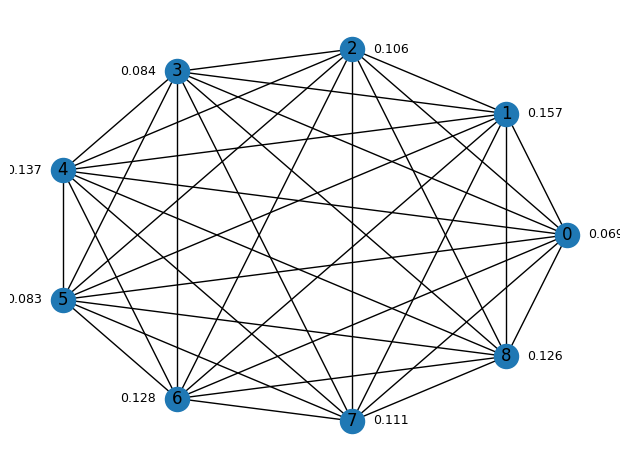

["Hunt ban support is 'in decline'..", "Support for a ban on hunting has fallen in the past six years, a poll suggests...Less than half the UK wants a ban compared to almost two-thirds in 1999, the Mori survey of 2,000 adults for BBC One's Countryfile programme suggests.", 'The number opposed to a ban remains constant, but those "neither supporting nor opposing" has increased by 11%.', 'Most city-dwellers support the ban but rural people were evenly split between supporters, opponents and undecided...Polling company Mori carried out both surveys.', 'In July 1999 they asked 801 adults if they supported the ban for the Mail on Sunday.', 'For Countryfile they asked 2,234 adults across the country the same question.', 'The Mail on Sunday survey found that 63% supported a hunting ban compared with 24% against.', 'In the Countryfile survey, 47% said they supported the legislation, with 26% against.', 'But the programme makers suggest the British public are becoming "increasingly neutral" to 

In [ ]:
x=dataset_sum2_test[76]['Articles']
_, word_list = tokenize_sent(x.strip(), all=True)

g,_=build_graph_sent(word_list)
calculated_page_rank = _pagerank_scipy(g)
node_labels={i:round(x,3) for (i,x) in calculated_page_rank.items()}
pos = nx.circular_layout(g)
pos_higher = {}
for k, v in pos.items():
  if v[0]>0:
    pos_higher[k] = (v[0]+0.15, v[1])
  else:
    pos_higher[k] = (v[0]-0.15, v[1])
nx.draw_networkx_labels(g,pos_higher,labels=node_labels, font_size=9)
nx.draw(g, pos, with_labels=True)
plt.tight_layout()
plt.show()
y_pred = extract_sentences(x, all=True, verbose=True)
y = dataset_sum2_test['Summaries'][76]

In [ ]:
print(len(y_pred.split(' ')))

101


In [ ]:
y = dataset_sum2_test['Summaries'][100]
print(y)

Former welfare minister Frank Field MP said the prime minister should sack Mr Brown, but did not believe Mr Blair was strong enough to do so.Mr Blair said the claims were "reheated from six months ago" and that he was concentrating on running the country.The Liberal Democrat parliamentary chairman Matthew Taylor said the personal ambition of Mr Blair and Mr Brown was "getting in the way of good government".According to Mr Peston the prime minister said: "Help me to get through the year and I will then stand down."According to a new book, Brown's Britain, Mr Blair went back on a pledge to make way for Mr Brown after Cabinet allies intervened in June 2004.Mr Blair said: "I've dealt with this six months ago.And that at a dinner hosted by Deputy Prime Minister John Prescott he told Mr Brown of his intention to stand down.During the interview Mr Blair also said the former home secretary David Blunkett would play a "big role" at the general election.Tory leader Michael Howard accused the pri

In [ ]:
scorer1 = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
score1 = scorer1.score(y, y_pred)
print(score1)

{'rouge1': Score(precision=0.7428571428571429, recall=1.0, fmeasure=0.8524590163934427)}


## 3.2 Base

In [ ]:
f1_1,f1_2 = proc_sum(all=True)
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.634
Mean ROUGE Score (stem): 0.638
Max ROUGE Score: 1.0 (Index: 92)
Max ROUGE Score (stem): 1.0 (Index: 92)


In [28]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum2(all=True)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)


Mean ROUGE Score: 0.339
Mean ROUGE Score (stem): 0.356
Max ROUGE Score: 0.5045045045045046 (Index: 36)
Max ROUGE Score (stem): 0.5327510917030567 (Index: 79)
ROUGE-L-----------
Mean ROUGE Score: 0.174
Mean ROUGE Score (stem): 0.179
Max ROUGE Score: 0.27027027027027023 (Index: 36)
Max ROUGE Score (stem): 0.2794759825327511 (Index: 79)


## 3.3 Select Keywords by Tag + remove stop-words

In [ ]:
# noun adjective propnoun
f1_1,f1_2 = proc_sum()
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.683
Mean ROUGE Score (stem): 0.686
Max ROUGE Score: 1.0 (Index: 101)
Max ROUGE Score (stem): 1.0 (Index: 101)


In [ ]:
f1_1,f1_2 = proc_sum(tags=['NOUN','ADJ','PROPN','VERB'])
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.697
Mean ROUGE Score (stem): 0.699
Max ROUGE Score: 1.0 (Index: 101)
Max ROUGE Score (stem): 1.0 (Index: 101)


In [ ]:
# all pos tags except symbols, punctuation, 'others' and spaces
POS_LIST = ["ADJ", "ADP", "ADV", "AUX", "CONJ", "CCONJ", "DET", "INTJ", "NOUN", "NUM", "PART", "PRON", "PROPN", "SCONJ", "VERB"]
f1_1,f1_2 = proc_sum(tags=POS_LIST)
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.695
Mean ROUGE Score (stem): 0.698
Max ROUGE Score: 1.0 (Index: 101)
Max ROUGE Score (stem): 1.0 (Index: 101)


In [29]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum2(all=False)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.344
Mean ROUGE Score (stem): 0.360
Max ROUGE Score: 0.5284552845528455 (Index: 77)
Max ROUGE Score (stem): 0.5365853658536585 (Index: 77)
ROUGE-L-----------
Mean ROUGE Score: 0.179
Mean ROUGE Score (stem): 0.184
Max ROUGE Score: 0.30392156862745096 (Index: 105)
Max ROUGE Score (stem): 0.30392156862745096 (Index: 105)


In [30]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum2(all=False, tags=['NOUN','ADJ','PROPN','VERB'])
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.337
Mean ROUGE Score (stem): 0.353
Max ROUGE Score: 0.5339366515837104 (Index: 79)
Max ROUGE Score (stem): 0.5610859728506787 (Index: 79)
ROUGE-L-----------
Mean ROUGE Score: 0.179
Mean ROUGE Score (stem): 0.184
Max ROUGE Score: 0.2895927601809954 (Index: 79)
Max ROUGE Score (stem): 0.3167420814479638 (Index: 79)


In [31]:
POS_LIST = ["ADJ", "ADP", "ADV", "AUX", "CONJ", "CCONJ", "DET", "INTJ", "NOUN", "NUM", "PART", "PRON", "PROPN", "SCONJ", "VERB"]
f1_1, f1_2, f1_L1, f1_L2 =proc_sum2(all=False, tags=POS_LIST)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.337
Mean ROUGE Score (stem): 0.353
Max ROUGE Score: 0.5339366515837104 (Index: 79)
Max ROUGE Score (stem): 0.5610859728506787 (Index: 79)
ROUGE-L-----------
Mean ROUGE Score: 0.179
Mean ROUGE Score (stem): 0.185
Max ROUGE Score: 0.2895927601809954 (Index: 79)
Max ROUGE Score (stem): 0.3167420814479638 (Index: 79)


## 3.4 Lemmatize



In [57]:
f1_1,f1_2 = proc_sum(lemmatize=True)
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.686
Mean ROUGE Score (stem): 0.688
Max ROUGE Score: 1.0 (Index: 225)
Max ROUGE Score (stem): 1.0 (Index: 225)


In [58]:
f1_1,f1_2 = proc_sum(lemmatize=True, all=True)
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.630
Mean ROUGE Score (stem): 0.634
Max ROUGE Score: 1.0 (Index: 837)
Max ROUGE Score (stem): 1.0 (Index: 837)


In [53]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum2(lemmatize=True)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.345
Mean ROUGE Score (stem): 0.361
Max ROUGE Score: 0.5284552845528455 (Index: 77)
Max ROUGE Score (stem): 0.5365853658536585 (Index: 77)
ROUGE-L-----------
Mean ROUGE Score: 0.180
Mean ROUGE Score (stem): 0.186
Max ROUGE Score: 0.30392156862745096 (Index: 105)
Max ROUGE Score (stem): 0.30392156862745096 (Index: 105)


In [54]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum2(all=True,lemmatize=True)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.329
Mean ROUGE Score (stem): 0.347
Max ROUGE Score: 0.5339366515837104 (Index: 79)
Max ROUGE Score (stem): 0.5610859728506787 (Index: 79)
ROUGE-L-----------
Mean ROUGE Score: 0.167
Mean ROUGE Score (stem): 0.172
Max ROUGE Score: 0.2895927601809954 (Index: 79)
Max ROUGE Score (stem): 0.3167420814479638 (Index: 79)


## 3.5 Levenshtein Distance

In [32]:
!pip install editdistance

Levenshtein distance measures no. changes need to be made to one sentence (in this case list of words) to turn it into another sentence. Higher LD = larger difference. Pagerank however interprets larger weights as meaning that two nodes are more similar. We must edit the LD to make it suitable for Pagerank.

In [33]:
def levenshtein_dif(i,j):
  m = max(len(i),len(j))
  return m-editdistance.eval(i,j)

In [ ]:
f1_1,f1_2 = proc_sum(all=True,fx=levenshtein_dif)
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.594
Mean ROUGE Score (stem): 0.599
Max ROUGE Score: 1.0 (Index: 524)
Max ROUGE Score (stem): 1.0 (Index: 524)


In [ ]:
f1_1,f1_2 = proc_sum(fx=levenshtein_dif, all=False)
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.650
Mean ROUGE Score (stem): 0.654
Max ROUGE Score: 1.0 (Index: 101)
Max ROUGE Score (stem): 1.0 (Index: 101)


In [ ]:
f1_1,f1_2 = proc_sum(all=False, fx=levenshtein_dif, lemmatize=True)
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.653
Mean ROUGE Score (stem): 0.656
Max ROUGE Score: 1.0 (Index: 524)
Max ROUGE Score (stem): 1.0 (Index: 524)


In [34]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum2(all=True,fx=levenshtein_dif)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.296
Mean ROUGE Score (stem): 0.313
Max ROUGE Score: 0.5041322314049586 (Index: 145)
Max ROUGE Score (stem): 0.5041322314049586 (Index: 145)
ROUGE-L-----------
Mean ROUGE Score: 0.158
Mean ROUGE Score (stem): 0.162
Max ROUGE Score: 0.2892561983471075 (Index: 145)
Max ROUGE Score (stem): 0.2892561983471075 (Index: 145)


In [35]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum2( all=False,fx=levenshtein_dif)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.332
Mean ROUGE Score (stem): 0.348
Max ROUGE Score: 0.4978165938864629 (Index: 124)
Max ROUGE Score (stem): 0.5221238938053097 (Index: 165)
ROUGE-L-----------
Mean ROUGE Score: 0.174
Mean ROUGE Score (stem): 0.180
Max ROUGE Score: 0.3318777292576419 (Index: 124)
Max ROUGE Score (stem): 0.3318777292576419 (Index: 124)


In [36]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum2(all=False, fx=levenshtein_dif, lemmatize=True)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.329
Mean ROUGE Score (stem): 0.345
Max ROUGE Score: 0.4978165938864629 (Index: 124)
Max ROUGE Score (stem): 0.5221238938053097 (Index: 165)
ROUGE-L-----------
Mean ROUGE Score: 0.175
Mean ROUGE Score (stem): 0.180
Max ROUGE Score: 0.3056768558951965 (Index: 99)
Max ROUGE Score (stem): 0.3056768558951965 (Index: 99)


## 3.7 TFIDF Cosine Similarity

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
def build_graph_sent_tfidf(word_list):
  gr = nx.Graph() #undirected graph
  gr.add_nodes_from(range(len(word_list)))

  x = [' '.join(listy) for listy in word_list]
  tfidf_vectorizer = TfidfVectorizer()
  tfidf_matrix = tfidf_vectorizer.fit_transform(x)
  cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

  for i,sent in enumerate(word_list):
    if len(sent)>0:
      co_occur = [id for id in range(len(word_list)) if id!=i]
      for j in co_occur:
        if len(word_list[j])>0:
          if gr.has_edge(i, j):
            pass
          else:
            gr.add_edge(i, j, weight=cosine_sim[i][j])
  return gr, len(gr.nodes)

In [18]:
def extract_sentences_tfidf(text, all=False, lemmatize=False, tags=['NOUN', 'ADJ', 'PROPN'], verbose=False, gr_fx=build_graph_sent_tfidf):
  """Return a paragraph formatted summary of the source text.

  :param text: A string.
  """
  sent_list, word_list = tokenize_sent(text.strip(), all=all, lemmatize=lemmatize, tags=tags)
  graph,_ = gr_fx(word_list)

  if verbose:
    print(sent_list)
    print(word_list)

  calculated_page_rank = _pagerank_scipy(graph, weight='weight', verbose=verbose)

  # sentence ids in descending order of importance
  sorted_sent_ids = sorted(calculated_page_rank, key=calculated_page_rank.get,reverse=True)
  # sorted_sents = [sent_list[i] for i in sorted_sent_ids]
  if verbose:
    print(sorted_sent_ids)

  # return a 100 word summary
  finallen = 0
  sorted_sents = []
  for id in sorted_sent_ids:
    sentlen = len(sent_list[id].split(' '))
    if finallen + sentlen<100:
      sorted_sents.append(sent_list[id])
      finallen += sentlen
      # print(id)
    elif (finallen+sentlen-100)<(100-sentlen): #adding more words takes it closer to 100 words
      sorted_sents.append(sent_list[id])
      finallen += sentlen
      # print(id)
      break
    else:
      break
  summary = ' '.join(sorted_sents)



  return summary

In [19]:
def proc_sum_tfidf(all=False, lemmatize=False, tags=['NOUN', 'ADJ', 'PROPN'], gr_fx=build_graph_sent_tfidf, verbose=False):
  l = len(dataset_sum2_test)
  f1_1, f1_2 = np.zeros(l),np.zeros(l)
  for i, data in enumerate(dataset_sum2_test):
    X = dataset_sum2_test[i]["Articles"]
    y = dataset_sum2_test[i]["Summaries"]

    y_pred = extract_sentences_tfidf(X, all=all, lemmatize=lemmatize, tags=tags, verbose=verbose, gr_fx=gr_fx)

    scorer1 = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=False)
    scorer2 = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

    score1 = scorer1.score(y, y_pred)
    score2 = scorer2.score(y, y_pred)

    f1_1[i] = score1['rouge1'].fmeasure
    f1_2[i] = score2['rouge1'].fmeasure

  return f1_1,f1_2

In [20]:
def proc_sum_tfidf2(all=False, lemmatize=False, tags=['NOUN', 'ADJ', 'PROPN'], gr_fx=build_graph_sent_tfidf, verbose=False):
  l = len(dataset_sum3_test)
  f1_1, f1_2,f1_L1, f1_L2 = np.zeros(l),np.zeros(l), np.zeros(l),np.zeros(l)
  for i, data in enumerate(dataset_sum3_test):
    X = dataset_sum3_test[i]["document"]
    y = dataset_sum3_test[i]["summary"]

    y_pred = extract_sentences_tfidf(X, all=all, lemmatize=lemmatize, tags=tags, verbose=verbose, gr_fx=gr_fx)

    scorer1 = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=False)
    scorer2 = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)

    score1 = scorer1.score(y, y_pred)
    score2 = scorer2.score(y, y_pred)

    f1_1[i] = score1['rouge1'].fmeasure
    f1_2[i] = score2['rouge1'].fmeasure
    f1_L1[i] = score1['rougeL'].fmeasure
    f1_L2[i] = score2['rougeL'].fmeasure

  return f1_1,f1_2, f1_L1, f1_L2

In [ ]:
f1_1,f1_2 = proc_sum_tfidf(all=True)
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.641
Mean ROUGE Score (stem): 0.644
Max ROUGE Score: 1.0 (Index: 837)
Max ROUGE Score (stem): 1.0 (Index: 837)


In [ ]:
f1_1,f1_2 = proc_sum_tfidf(lemmatize=False, all=False)
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.683
Mean ROUGE Score (stem): 0.686
Max ROUGE Score: 1.0 (Index: 539)
Max ROUGE Score (stem): 1.0 (Index: 539)


In [ ]:
f1_1,f1_2 = proc_sum_tfidf(lemmatize=True, all=False)
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.684
Mean ROUGE Score (stem): 0.687
Max ROUGE Score: 1.0 (Index: 565)
Max ROUGE Score (stem): 1.0 (Index: 565)


In [50]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum_tfidf2(all=True)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.330
Mean ROUGE Score (stem): 0.345
Max ROUGE Score: 0.5339366515837104 (Index: 79)
Max ROUGE Score (stem): 0.5610859728506787 (Index: 79)
ROUGE-L-----------
Mean ROUGE Score: 0.181
Mean ROUGE Score (stem): 0.186
Max ROUGE Score: 0.3788546255506608 (Index: 105)
Max ROUGE Score (stem): 0.3788546255506608 (Index: 105)


In [51]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum_tfidf2(lemmatize=False, all=False)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.343
Mean ROUGE Score (stem): 0.359
Max ROUGE Score: 0.5224489795918368 (Index: 77)
Max ROUGE Score (stem): 0.5309734513274337 (Index: 36)
ROUGE-L-----------
Mean ROUGE Score: 0.180
Mean ROUGE Score (stem): 0.185
Max ROUGE Score: 0.2933333333333334 (Index: 135)
Max ROUGE Score (stem): 0.2933333333333334 (Index: 135)


In [52]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum_tfidf2(lemmatize=True, all=False)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.340
Mean ROUGE Score (stem): 0.357
Max ROUGE Score: 0.5224489795918368 (Index: 77)
Max ROUGE Score (stem): 0.5309734513274337 (Index: 36)
ROUGE-L-----------
Mean ROUGE Score: 0.179
Mean ROUGE Score (stem): 0.185
Max ROUGE Score: 0.2933333333333334 (Index: 135)
Max ROUGE Score (stem): 0.3008849557522124 (Index: 89)


## 3.8 Jaccard Similarity

In [37]:
def jaccard_similarity(i, j):
  s1 = set(i)
  s2 = set(j)
  return len(s1.intersection(s2))/ len(s1.union(s2))

In [ ]:
f1_1,f1_2 = proc_sum(all=True,fx=jaccard_similarity)
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.655
Mean ROUGE Score (stem): 0.658
Max ROUGE Score: 1.0 (Index: 92)
Max ROUGE Score (stem): 1.0 (Index: 92)


In [ ]:
f1_1,f1_2 = proc_sum(all=False,fx=jaccard_similarity)
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.690
Mean ROUGE Score (stem): 0.692
Max ROUGE Score: 1.0 (Index: 101)
Max ROUGE Score (stem): 1.0 (Index: 101)


In [ ]:
f1_1,f1_2 = proc_sum(all=False,lemmatize=True, fx=jaccard_similarity)
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.691
Mean ROUGE Score (stem): 0.694
Max ROUGE Score: 1.0 (Index: 284)
Max ROUGE Score (stem): 1.0 (Index: 284)


In [38]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum2(all=True,fx=jaccard_similarity)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.334
Mean ROUGE Score (stem): 0.348
Max ROUGE Score: 0.5 (Index: 103)
Max ROUGE Score (stem): 0.5205479452054793 (Index: 79)
ROUGE-L-----------
Mean ROUGE Score: 0.175
Mean ROUGE Score (stem): 0.179
Max ROUGE Score: 0.2884615384615385 (Index: 103)
Max ROUGE Score (stem): 0.2884615384615385 (Index: 103)


In [39]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum2(all=False,fx=jaccard_similarity)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.334
Mean ROUGE Score (stem): 0.349
Max ROUGE Score: 0.4909090909090909 (Index: 36)
Max ROUGE Score (stem): 0.5181818181818182 (Index: 36)
ROUGE-L-----------
Mean ROUGE Score: 0.179
Mean ROUGE Score (stem): 0.184
Max ROUGE Score: 0.3008849557522123 (Index: 164)
Max ROUGE Score (stem): 0.3097345132743363 (Index: 164)


In [40]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum2(all=False,lemmatize=True, fx=jaccard_similarity)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.334
Mean ROUGE Score (stem): 0.351
Max ROUGE Score: 0.5132743362831858 (Index: 36)
Max ROUGE Score (stem): 0.5309734513274337 (Index: 36)
ROUGE-L-----------
Mean ROUGE Score: 0.177
Mean ROUGE Score (stem): 0.182
Max ROUGE Score: 0.2922374429223744 (Index: 76)
Max ROUGE Score (stem): 0.2922374429223744 (Index: 76)


## 3.9 Sorensen-Dice Similarity

In [41]:
def dice_sim(i, j):
  s1 = set(i)
  s2 = set(j)
  return 2*len(s1.intersection(s2))/ (len(s1)+len(s2))

In [ ]:
f1_1,f1_2 = proc_sum(all=True,fx=dice_sim)
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.652
Mean ROUGE Score (stem): 0.656
Max ROUGE Score: 1.0 (Index: 92)
Max ROUGE Score (stem): 1.0 (Index: 92)


In [ ]:
f1_1,f1_2 = proc_sum(all=False,fx=dice_sim)
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.690
Mean ROUGE Score (stem): 0.693
Max ROUGE Score: 1.0 (Index: 101)
Max ROUGE Score (stem): 1.0 (Index: 101)


In [ ]:
f1_1,f1_2 = proc_sum(all=False,lemmatize=True, fx=dice_sim)
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.691
Mean ROUGE Score (stem): 0.694
Max ROUGE Score: 1.0 (Index: 284)
Max ROUGE Score (stem): 1.0 (Index: 284)


In [42]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum2(all=True,fx=dice_sim)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.339
Mean ROUGE Score (stem): 0.353
Max ROUGE Score: 0.5142857142857143 (Index: 103)
Max ROUGE Score (stem): 0.5333333333333333 (Index: 103)
ROUGE-L-----------
Mean ROUGE Score: 0.175
Mean ROUGE Score (stem): 0.179
Max ROUGE Score: 0.28571428571428564 (Index: 103)
Max ROUGE Score (stem): 0.28571428571428564 (Index: 103)


In [43]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum2(all=False,fx=dice_sim)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.342
Mean ROUGE Score (stem): 0.359
Max ROUGE Score: 0.5121951219512195 (Index: 77)
Max ROUGE Score (stem): 0.5203252032520326 (Index: 77)
ROUGE-L-----------
Mean ROUGE Score: 0.180
Mean ROUGE Score (stem): 0.185
Max ROUGE Score: 0.27999999999999997 (Index: 76)
Max ROUGE Score (stem): 0.27999999999999997 (Index: 76)


In [44]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum2(all=False, lemmatize=True, fx=dice_sim)
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.334
Mean ROUGE Score (stem): 0.352
Max ROUGE Score: 0.5132743362831858 (Index: 36)
Max ROUGE Score (stem): 0.5309734513274337 (Index: 36)
ROUGE-L-----------
Mean ROUGE Score: 0.179
Mean ROUGE Score (stem): 0.185
Max ROUGE Score: 0.2922374429223744 (Index: 76)
Max ROUGE Score (stem): 0.2922374429223744 (Index: 76)


## 3.10 Sent to Vec

In [21]:
!pip install sent2vec
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [22]:
from sent2vec.vectorizer import Vectorizer
from scipy import spatial
import torch as torch

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [24]:
def build_graph_sent_s2v(word_list):
  gr = nx.Graph() #undirected graph
  gr.add_nodes_from(range(len(word_list)))

  x = [' '.join(listy) for listy in word_list]
  vectorizer = Vectorizer()
  vectorizer.run(x)
  vectors = vectorizer.vectors

  for i,sent in enumerate(word_list):
    if len(sent)>0:
      co_occur = [id for id in range(len(word_list)) if id!=i]
      for j in co_occur:
        if len(word_list[j])>0:
          if gr.has_edge(i, j):
            pass
          else:
            gr.add_edge(i, j, weight=spatial.distance.cosine(vectors[i], vectors[j]))
  return gr, len(gr.nodes)

In [ ]:
f1_1,f1_2 = proc_sum_tfidf(all=False, gr_fx=build_graph_sent_s2v)

Initializing Bert distilbert-base-uncased
Vectorization done on cpu


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vector

In [ ]:
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.526
Mean ROUGE Score (stem): 0.534
Max ROUGE Score: 0.9441624365482234 (Index: 617)
Max ROUGE Score (stem): 0.9441624365482234 (Index: 617)


In [ ]:
f1_1,f1_2 = proc_sum_tfidf(all=True, gr_fx=build_graph_sent_s2v)

Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vectorization done on cpu
Initializing Bert distilbert-base-uncased
Vector

In [ ]:
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.512
Mean ROUGE Score (stem): 0.520
Max ROUGE Score: 0.9292929292929293 (Index: 905)
Max ROUGE Score (stem): 0.9292929292929293 (Index: 905)


In [24]:
f1_1,f1_2 = proc_sum_tfidf(all=False, lemmatize=True, gr_fx=build_graph_sent_s2v)

Initializing Bert distilbert-base-uncased
Vectorization done on cuda


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-

In [25]:
print_stats_sum(f1_1,f1_2)

Mean ROUGE Score: 0.527
Mean ROUGE Score (stem): 0.534
Max ROUGE Score: 0.944 (Index: 565)
Max ROUGE Score (stem): 0.944 (Index: 565)


In [25]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum_tfidf2(lemmatize=False, all=True, gr_fx=build_graph_sent_s2v)

Initializing Bert distilbert-base-uncased
Vectorization done on cuda


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-

In [26]:
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.276
Mean ROUGE Score (stem): 0.289
Max ROUGE Score: 0.43442622950819676 (Index: 122)
Max ROUGE Score (stem): 0.47619047619047616 (Index: 180)
ROUGE-L-----------
Mean ROUGE Score: 0.139
Mean ROUGE Score (stem): 0.142
Max ROUGE Score: 0.23214285714285712 (Index: 174)
Max ROUGE Score (stem): 0.23580786026200873 (Index: 16)


In [27]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum_tfidf2(lemmatize=False, all=False, gr_fx=build_graph_sent_s2v)

Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-

In [28]:
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.286
Mean ROUGE Score (stem): 0.303
Max ROUGE Score: 0.44239631336405527 (Index: 7)
Max ROUGE Score (stem): 0.4700460829493087 (Index: 7)
ROUGE-L-----------
Mean ROUGE Score: 0.146
Mean ROUGE Score (stem): 0.151
Max ROUGE Score: 0.26495726495726496 (Index: 105)
Max ROUGE Score (stem): 0.26495726495726496 (Index: 105)


In [29]:
f1_1, f1_2, f1_L1, f1_L2 =proc_sum_tfidf2(lemmatize=True, all=False, gr_fx=build_graph_sent_s2v)

Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-uncased
Vectorization done on cuda
Initializing Bert distilbert-base-

In [30]:
print_stats_sum(f1_1,f1_2)
print("ROUGE-L-----------")
print_stats_sum(f1_L1,f1_L2)

Mean ROUGE Score: 0.280
Mean ROUGE Score (stem): 0.295
Max ROUGE Score: 0.4978165938864629 (Index: 183)
Max ROUGE Score (stem): 0.5152838427947598 (Index: 183)
ROUGE-L-----------
Mean ROUGE Score: 0.142
Mean ROUGE Score (stem): 0.146
Max ROUGE Score: 0.25108225108225113 (Index: 124)
Max ROUGE Score (stem): 0.25327510917030566 (Index: 183)
